# Task 15: Customer Segmentation (RFM Analysis)

## 1. Objective
The goal of this analysis is to segment customers based on their purchasing behavior using the **RFM (Recency, Frequency, Monetary)** model. By identifying different customer groups (e.g., Champions, At Risk, New Customers), we can tailor marketing strategies to maximize retention and revenue.

### What is RFM Analysis?
- **Recency (R)**: How recently did the customer purchase? (Lower is better)
- **Frequency (F)**: How often do they purchase? (Higher is better)
- **Monetary (M)**: How much do they spend? (Higher is better)

**Tools Used:** Python, Pandas, Matplotlib, Seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Set plot style for better aesthetics
sns.set(style="whitegrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Loading & Inspection
We start by loading the dataset and inspecting its structure to understand the variables available.

In [2]:
# Load dataset
# Attempting different encodings to handle potential issues
try:
    df = pd.read_csv('data.csv', encoding='ISO-8859-1')
except UnicodeDecodeError:
    df = pd.read_csv('data.csv', encoding='utf-8')

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 3. Data Cleaning
To ensure accurate analysis, we must:
1.  **Remove missing CustomerIDs**: We cannot segment unidentified customers.
2.  **Remove cancelled orders**: Transactions starting with 'C' in `InvoiceNo` are cancellations and should not count as valid sales.
3.  **Convert Data Types**: `InvoiceDate` needs to be in datetime format.
4.  **Calculate Total Price**: `Quantity` * `UnitPrice` gives the total monetary value per transaction.

In [3]:
# 1. Drop missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# 2. Remove cancelled orders
df = df[~df['InvoiceNo'].str.contains('C', na=False)]

# 3. Convert InvoiceDate
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 4. Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Verify cleaning
print("Cleaned Data Shape:", df.shape)
print("Date Range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())

Cleaned Data Shape: (397924, 9)
Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


## 4. RFM Feature Engineering
We aggregate the data at the customer level to calculate R, F, and M values.
- **Snapshot Date**: We use the day after the last transaction in the dataset as the reference point for Recency.

In [4]:
# Define reference date (1 day after max date)
latest_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Aggregate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                                # Frequency
    'TotalPrice': 'sum'                                    # Monetary
}).reset_index()

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# Filter out any potential zero or negative monetary values (if returns weren't fully caught)
rfm = rfm[rfm['Monetary'] > 0]

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


### 4.1 Exploratory Analysis of RFM Distributions
Let's visualize the distribution of Recency, Frequency, and Monetary to understand the customer base behavior.

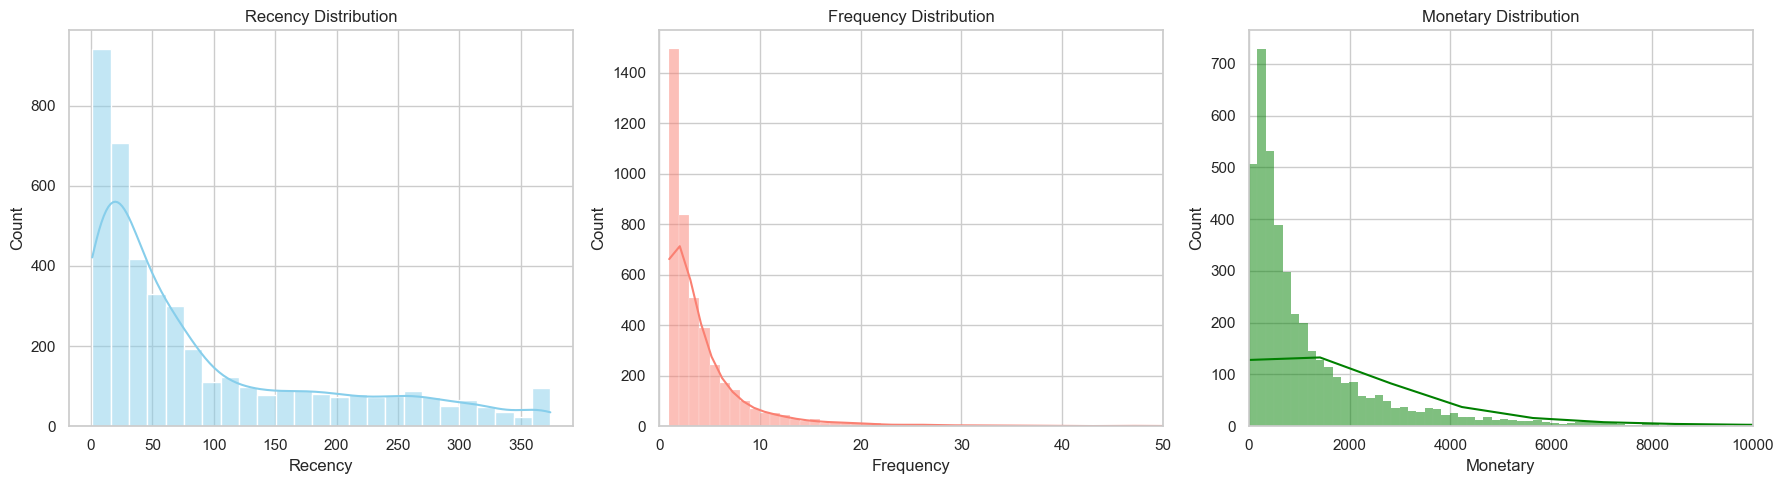

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Recency Distribution
sns.histplot(rfm['Recency'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Recency Distribution')

# Frequency Distribution (Log scale for better visibility)
sns.histplot(rfm['Frequency'], kde=True, ax=ax[1], color='salmon', binwidth=1)
ax[1].set_title('Frequency Distribution')
ax[1].set_xlim(0, 50) # Zoom in to see the bulk of customers

# Monetary Distribution (Log scale recommended often, but let's just create a standard plot first)
sns.histplot(rfm['Monetary'], kde=True, ax=ax[2], color='green')
ax[2].set_title('Monetary Distribution')
ax[2].set_xlim(0, 10000) # Limit to remove extreme outliers

plt.tight_layout()
plt.show()

## 5. RFM Scoring & Segmentation
We assign scores from 1 to 4 based on quartiles:
- **Recency Score**: 4 is Best (Most recent), 1 is Worst (Long time ago).
- **Frequency Score**: 4 is Best (Most frequent), 1 is Worst (Fewest orders).
- **Monetary Score**: 4 is Best (High spender), 1 is Worst (Low spender).

*Note: For Recency, we swap the labels because standard qcut assigns higher labels to higher values (higher days = worse recency).*

In [6]:
# Create Quartiles (1-4)
r_labels = range(4, 0, -1) # Recency: 4, 3, 2, 1 (Lower days = Higher score)
f_labels = range(1, 5)     # Frequency: 1, 2, 3, 4
m_labels = range(1, 5)     # Monetary: 1, 2, 3, 4

rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=m_labels).astype(int)

# Combine RFM Scores into a single string
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Calculate a combined RFM Score sum for simplified segmentation
rfm['RFM_Score_Sum'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score_Sum
0,12346.0,326,1,77183.60,1,1,4,114,6
1,12347.0,2,7,4310.00,4,4,4,444,12
2,12348.0,75,4,1797.24,2,3,4,234,9
3,12349.0,19,1,1757.55,3,1,4,314,8
4,12350.0,310,1,334.40,1,1,2,112,4


### 5.1 Define Customer Segments
We use a regex-based mapping (or score-sum logic) to assign human-readable names to segments based on Recency and Frequency scores primarily, as these are most actionable for engagement.

In [7]:
def segment_customer(row):
    r = row['R_Score']
    f = row['F_Score']
    # Segment Map based on Recency and Frequency mostly
    if r >= 4 and f >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f >= 1:
        return 'Potential Loyalist'
    elif r >= 3 and f >= 1:
        return 'New Customers'
    elif r >= 3 and f >= 2:
        return 'Promising'
    elif r >= 2 and f >= 2:
        return 'Need Attention'
    elif r >= 2 and f >= 1:
        return 'About to Sleep'
    elif r >= 1 and f >= 2:
        return 'At Risk'
    elif r >= 1 and f >= 4:
        return 'Can\'t Lose Them'
    elif r >= 1 and f >= 1:
        return 'Hibernating'
    else:
        return 'Lost'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment']].head()

,CustomerID,Recency,Frequency,Monetary,Segment
0,12346.0,326,1,77183.60,Hibernating
1,12347.0,2,7,4310.00,Champions
2,12348.0,75,4,1797.24,Need Attention
3,12349.0,19,1,1757.55,New Customers
4,12350.0,310,1,334.40,Hibernating


## 6. Detailed Visualization of Segments
Visualizing the segments helps us understand the composition of our customer base.

C:\Users\ambar\AppData\Local\Temp\ipykernel_4720\625394840.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')


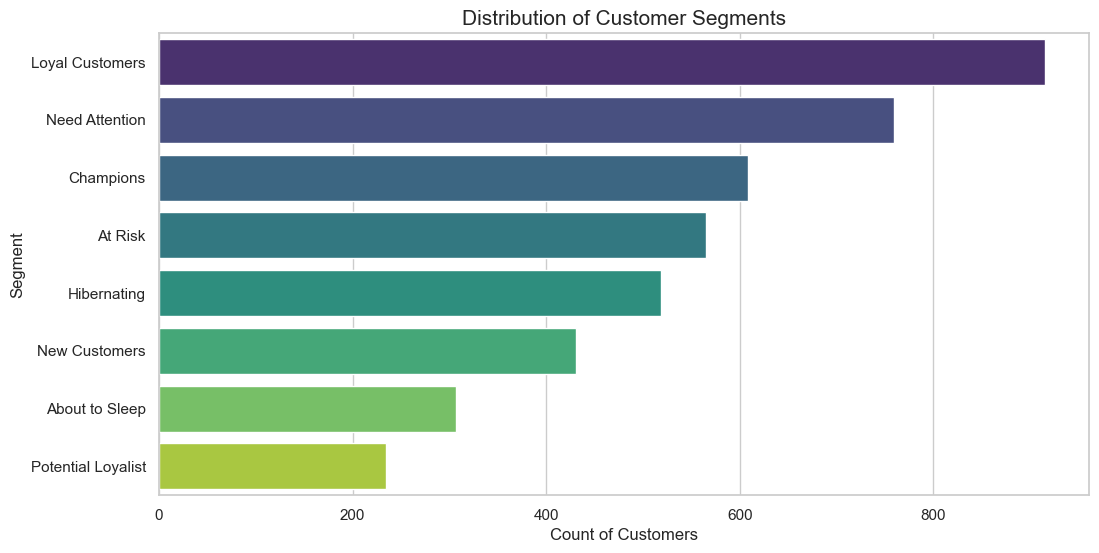

In [8]:
# 1. Count of Customers per Segment
plt.figure(figsize=(12, 6))
sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Distribution of Customer Segments', fontsize=15)
plt.xlabel('Count of Customers')
plt.ylabel('Segment')
plt.show()

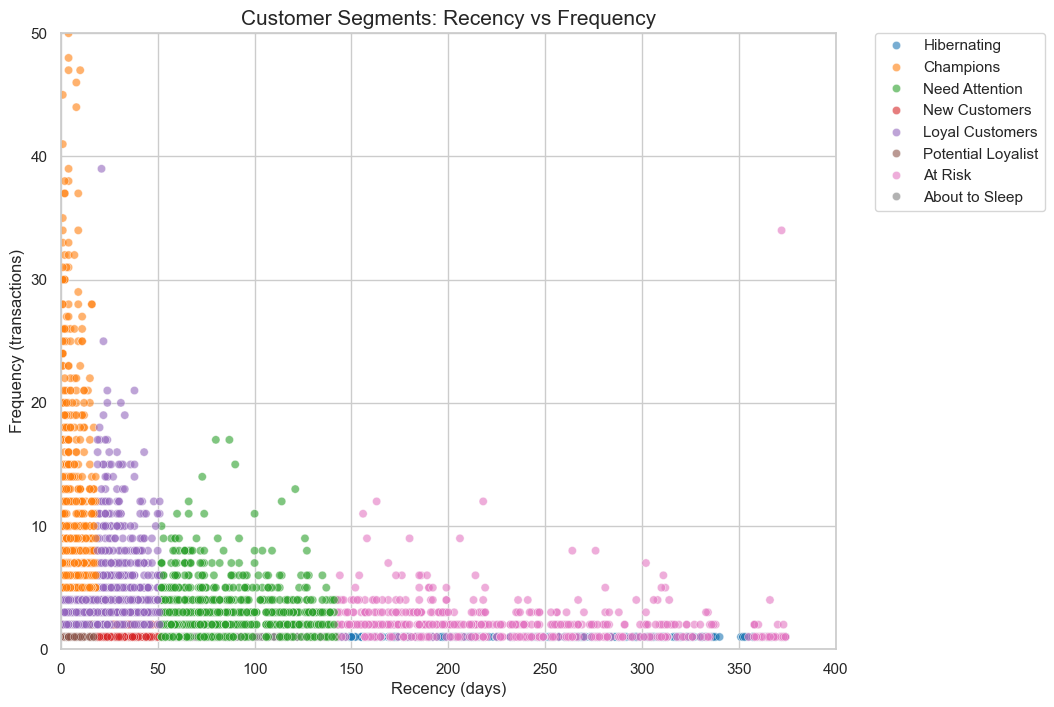

In [9]:
# 2. Scatter Plot: Recency vs Frequency
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=rfm, palette='tab10', sizes=(20, 200), alpha=0.6)
plt.title('Customer Segments: Recency vs Frequency', fontsize=15)
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (transactions)')
plt.xlim(0, 400)
plt.ylim(0, 50)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

C:\Users\ambar\AppData\Local\Temp\ipykernel_4720\2786699741.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Monetary', y='Segment', data=rfm, order=order, palette='Spectral', showfliers=False)


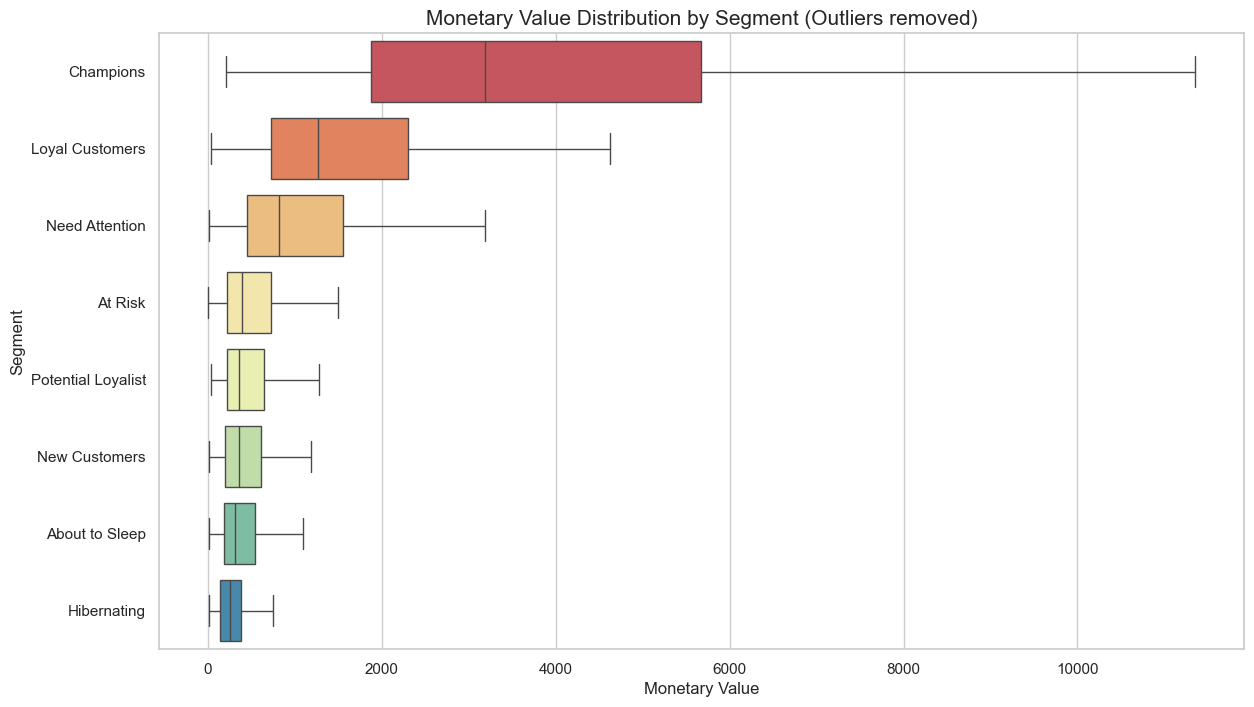

In [10]:
# 3. Boxplot of Monetary Value by Segment
plt.figure(figsize=(14, 8))
order = rfm.groupby('Segment')['Monetary'].median().sort_values(ascending=False).index
sns.boxplot(x='Monetary', y='Segment', data=rfm, order=order, palette='Spectral', showfliers=False)
plt.title('Monetary Value Distribution by Segment (Outliers removed)', fontsize=15)
plt.xlabel('Monetary Value')
plt.show()

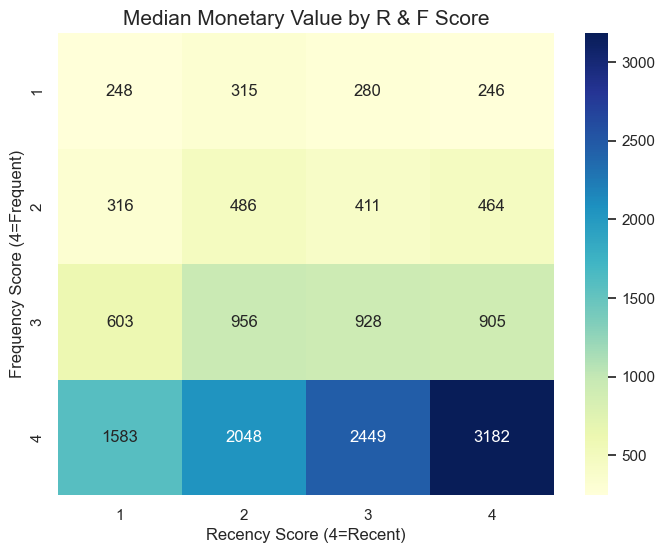

In [11]:
# 4. Heatmap of Frequency Score vs Recency Score
# This shows where the density of customers lies in the R-F grid
rfm_table = rfm.pivot_table(index='F_Score', columns='R_Score', values='Monetary', aggfunc=np.median)
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_table, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Median Monetary Value by R & F Score', fontsize=15)
plt.xlabel('Recency Score (4=Recent)')
plt.ylabel('Frequency Score (4=Frequent)')
plt.show()

## 7. Business Actions & Recommendations

Based on the analysis, here are targeted strategies for key segments:

### **Champions (High R, High F, High M)**
- **Strategy**: Maintain engagement, reward loyalty.
- **Actions**:
    1. Offer early access to new products.
    2. Invite to special VIP events.
    3. Ask for reviews and referrals.

### **Loyal Customers (Good R, Good F)**
- **Strategy**: Upsell and cross-sell to increase value.
- **Actions**:
    1. Recommend products based on purchase history.
    2. Offer volume discounts.
    3. Include in loyalty point programs.

### **At Risk (Low R, Good/High F)**
- **Strategy**: Reactivate before they are lost.
- **Actions**:
    1. Send personalized "We Miss You" emails.
    2. Offer a significant limited-time discount.
    3. Conduct a satisfaction survey to identify pain points.

### **New Customers (High R, Low F)**
- **Strategy**: Build a relationship and encourage second purchase.
- **Actions**:
    1. Send a welcome series email with a discount on the next order.
    2. Provide helpful content on how to use their purchased product.
    3. Offer free shipping on their next purchase.

In [12]:
# Export final data
rfm.to_csv('rfm_segments.csv', index=False)
print("Segments exported to 'rfm_segments.csv'")

Segments exported to 'rfm_segments.csv'
